# MODS206 - Data analysis in economics 2 - Applied Econometrics

### Authors:
* **João Lucas Furtado Melga**
* **Leonardo Hannas de Carvalho Santos**
* **Yuri de Sene Alvizi** 

---
## Imports of the the useful packages

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [64]:
!pip install arrow

---
## Exploratory data analysis

We first load the main dataset `traffic`.

In [65]:
traffic = pd.read_feather('codedDataset/trafficDataset.feather')
traffic

,city,station,weather,dow,datetime,hour,speed,vehicleType,energyConsumption,trafficCongestion,carCrash,pedestrianDeath
0,1,1,3,4,2021-04-01,0,31,2,9.35676,1,False,False
1,1,1,3,4,2021-04-01,0,38,2,8.35296,1,False,False
2,1,1,3,4,2021-04-01,0,29,3,11.29870,1,False,False
3,1,1,3,4,2021-04-01,0,42,1,6.56640,1,False,False
4,1,1,3,4,2021-04-01,0,41,2,7.99116,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
43952647,6,10,1,6,2021-07-31,0,40,1,6.75600,3,False,False
43952648,6,10,1,6,2021-07-31,0,48,2,7.30656,3,False,False
43952649,6,10,1,6,2021-07-31,0,43,2,7.77276,3,False,False
43952650,6,10,1,6,2021-07-31,0,44,3,8.94880,3,False,False


We now extract some useful statistics from the dataset. Namely, the mean and standard deviation, represented by the datasets `df_mean` and `df_std`, respectively.

In [66]:
df_mean = traffic.groupby('city').mean().drop(columns=['station', 'weather', 'dow', 'vehicleType', 'hour'])
df_mean

,speed,energyConsumption,trafficCongestion,carCrash,pedestrianDeath
city,,,,,
1,33.383528,9.552725,2.948498,0.002468,0.000330
2,39.501495,8.566721,2.975273,0.002963,0.000398
3,39.501675,8.566848,2.471608,0.002382,0.000325
4,39.501333,8.565293,1.180170,0.001197,0.000123
5,39.510016,8.566635,1.000000,0.000999,0.000145
6,39.497612,8.567330,2.917976,0.002884,0.000378


In [67]:
df_std = traffic.groupby('city').std().drop(columns=['station', 'weather', 'dow', 'vehicleType', 'hour'])
df_std

,speed,energyConsumption,trafficCongestion,carCrash,pedestrianDeath
city,,,,,
1,8.901254,2.098720,0.282210,0.049620,0.018166
2,5.007999,1.506273,0.185971,0.054357,0.019949
3,5.008598,1.506875,0.782969,0.048743,0.018024
4,5.009140,1.505781,0.384329,0.034576,0.011108
5,5.007146,1.506842,0.000000,0.031594,0.012061
6,5.008756,1.506719,0.349471,0.053624,0.019439


From the dataframe above, `df_std`, we see that the standard deviation of the speed of the **city 1** is higher. We will investigate it.

To that, we will load another dataset, the `city_info` dataset, shown below. 

In [68]:
city_info = pd.read_csv('info/cityInfo.csv')
city_info.columns = ['city', 'size', 'population', 'popDensity']
city_info

,city,size,population,popDensity
0,1,192,379909,1978.692708
1,2,91,453991,4988.912088
2,3,363,271008,746.578512
3,4,454,152110,335.044053
4,5,394,52620,133.553299
5,6,183,303659,1659.338798


Then, we merge the `df_mean` and the `city_info` datasets into the final dataset `df`.

In [69]:
df = df_mean.merge(city_info, on='city')
df

,city,speed,energyConsumption,trafficCongestion,carCrash,pedestrianDeath,size,population,popDensity
0,1,33.383528,9.552725,2.948498,0.002468,0.000330,192,379909,1978.692708
1,2,39.501495,8.566721,2.975273,0.002963,0.000398,91,453991,4988.912088
2,3,39.501675,8.566848,2.471608,0.002382,0.000325,363,271008,746.578512
3,4,39.501333,8.565293,1.180170,0.001197,0.000123,454,152110,335.044053
4,5,39.510016,8.566635,1.000000,0.000999,0.000145,394,52620,133.553299
5,6,39.497612,8.567330,2.917976,0.002884,0.000378,183,303659,1659.338798


Now, a *heatmap* of the correlation matrix of the `df` dataset is shown.

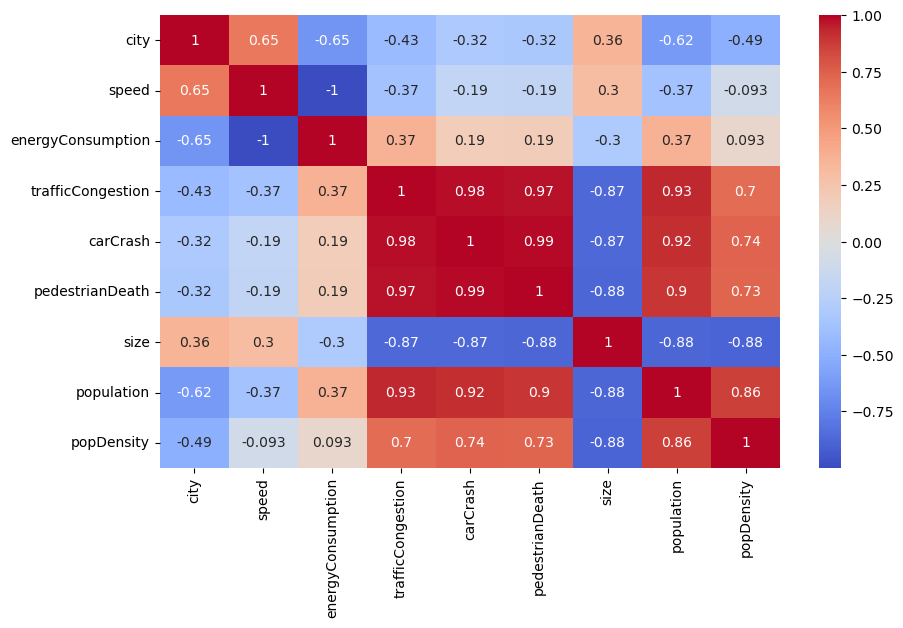

In [70]:
plt.figure(figsize=(10, 6), dpi=100)
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.show()

Since that we have constated that the standard deviation of the speed of the **city 1** is higher by checking the `df_std` dataset, we will grab the `traffic` dataset and perform a *groupby* operation, using the *day* as criteria to group the data. The we calculate the mean of the resulting data. The final result is stored in the `city_1` dataset. 

In [71]:
city_1 = traffic[traffic['city'] == 1].groupby(pd.Grouper(key='datetime', freq='D')).mean().drop(columns=['city', 'station', 'weather', 'dow', 'vehicleType', 'hour'])
city_1

,speed,energyConsumption,trafficCongestion,carCrash,pedestrianDeath
datetime,,,,,
2021-04-01,39.502444,8.563826,2.920885,0.002989,0.000338
2021-04-02,39.480170,8.570519,2.920581,0.002975,0.000489
2021-04-03,39.523594,8.556730,3.000000,0.003190,0.000479
2021-04-04,39.476120,8.568096,3.000000,0.003345,0.000368
2021-04-05,39.520970,8.565371,2.930426,0.002663,0.000334
...,...,...,...,...,...
2021-07-27,27.183649,10.555001,2.922449,0.002161,0.000259
2021-07-28,27.180771,10.558136,2.939915,0.002183,0.000258
2021-07-29,27.214167,10.553890,2.920430,0.001874,0.000272


Since we have perceived a clear **change in the parttern of both the speed and the energy consumption values according to the time**, we will plot this data, as well as the car crash data versus the time.

<Figure size 1000x600 with 0 Axes>

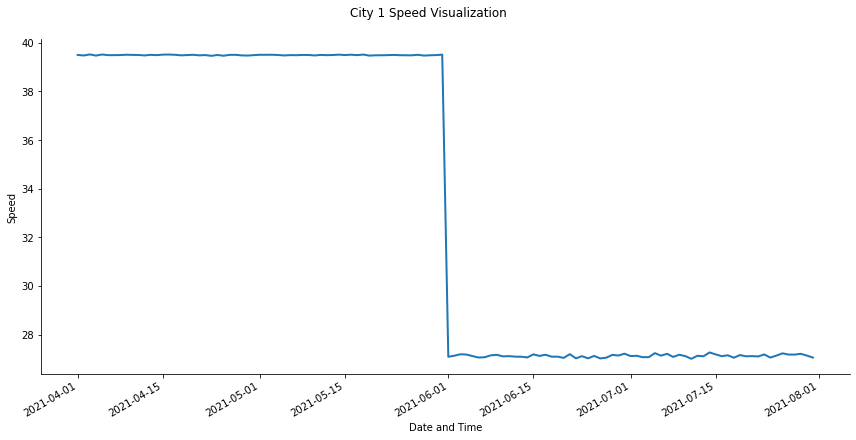

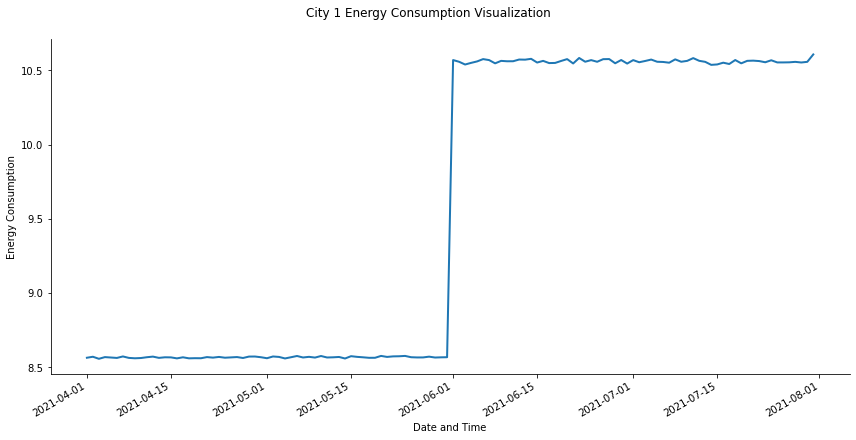

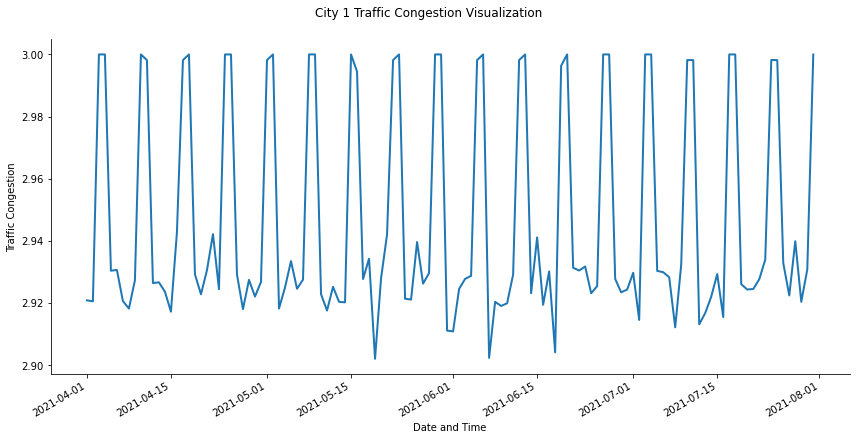

In [72]:
# City data visualization 
plt.figure(figsize=(10, 6), dpi=100)

# Speed vs Day
g1 = sns.relplot(x='datetime', y='speed', kind='line', data=city_1, height=6, aspect=2, linewidth=2)
g1.figure.autofmt_xdate() 
g1.set_xlabels('Date and Time')
g1.set_ylabels('Speed')
g1.figure.suptitle('City 1 Speed Visualization', y=1.05)

# Energy consumption vs Day
g2 = sns.relplot(x='datetime', y='energyConsumption', kind='line', data=city_1, height=6, aspect=2, linewidth=2)
g2.figure.autofmt_xdate()
g2.set_xlabels('Date and Time')
g2.set_ylabels('Energy Consumption')
g2.figure.suptitle('City 1 Energy Consumption Visualization', y=1.05)

# Traffic congestion vs Day
g3 = sns.relplot(x='datetime', y='trafficCongestion', kind='line', data=city_1, height=6, aspect=2, linewidth=2)
g3.figure.autofmt_xdate()
g3.set_xlabels('Date and Time')
g3.set_ylabels('Traffic Congestion')
g3.figure.suptitle('City 1 Traffic Congestion Visualization', y=1.05)

plt.show()

Now, we can see how this change of behavior in the **city 1** is represented when we perform an analysis in **each station of this city**. To do this, we will group the data by the *station* and the *day* and calculate the mean of the resulting data. The final result is stored in the `stations_city_1_mean` dataset.

In [73]:
stations_city_1_mean = traffic[traffic['city'] == 1].groupby(['station', pd.Grouper(key='datetime', freq='D')]).mean().drop(columns=['city', 'weather', 'dow', 'vehicleType', 'hour'])
stations_city_1_mean

speed  energyConsumption  trafficCongestion  carCrash  \
station datetime                                                                
1       2021-04-01  39.421352           8.586321           2.884873  0.003347   
        2021-04-02  39.434616           8.586430           2.772947  0.002332   
        2021-04-03  39.523284           8.562825           3.000000  0.003175   
        2021-04-04  39.538990           8.565154           3.000000  0.002136   
        2021-04-05  39.525909           8.564945           2.880901  0.003455   
...                       ...                ...                ...       ...   
10      2021-07-27  24.478435          10.987449           2.911271  0.002059   
        2021-07-28  24.520537          11.008755           2.912668  0.001830   
        2021-07-29  24.420923          10.987493           2.919844  0.001336   
        2021-07-30  24.469350          10.965828           2.930280  0.002156   
        2021-07-31  24.422000          11.069551           3.000000  0.002000   

                    pedestrianDeath  
station datetime                     
1       2021-04-01         0.000335  
        2021-04-02         0.000833  
        2021-04-03         0.000454  
        2021-04-04         0.000610  
        2021-04-05         0.000329  
...                             ...  
10      2021-07-27         0.000206  
        2021-07-28         0.000102  
        2021-07-29         0.000308  
        2021-07-30         0.000308  
        2021-07-31         0.000000  

[1220 rows x 5 columns]

We proceed similarly, but now we compute the standard deviation of the resulting data of the city 1. The final result is stored in the `stations_city_1_std` dataset.

In [74]:
stations_city_1_std =  traffic[traffic['city'] == 1].groupby(['station']).std().drop(columns=['city', 'weather', 'dow', 'vehicleType', 'hour'])
stations_city_1_std

,speed,energyConsumption,trafficCongestion,carCrash,pedestrianDeath
station,,,,,
1,9.003540,2.146350,0.408904,0.048072,0.017546
2,9.001536,2.148230,0.227418,0.048783,0.017631
3,9.007192,2.146495,0.220044,0.049049,0.017638
4,5.006400,1.506766,0.224130,0.053505,0.020232
5,9.008465,2.146914,0.298202,0.048956,0.017982
6,9.005037,2.146676,0.300439,0.047905,0.017916
7,5.004583,1.506096,0.414765,0.053696,0.019105
8,8.997093,2.145184,0.229075,0.048943,0.017961
9,9.009863,2.149017,0.236556,0.048882,0.017694


From the dataset above, `stations_city_1_std`, we see that **the stations 4 and 7 have lower speed standard deviations**. To visualize it, we will plot the values of the mean of the speed in the city 1, for each station, versus the time.

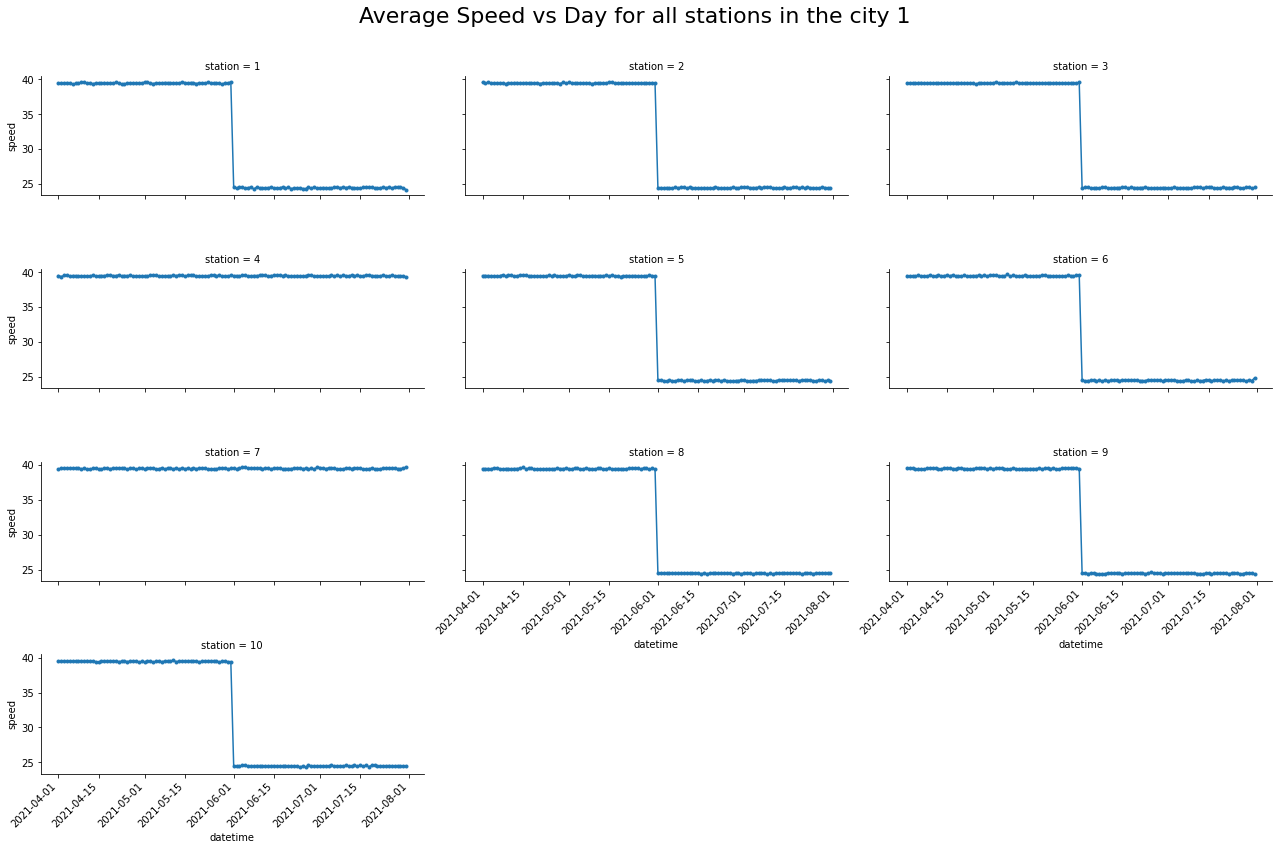

In [75]:
# Average speed vs Day for each station in the city 1
g = sns.FacetGrid(stations_city_1_mean.reset_index(), col="station", col_wrap=3, height=3, aspect=2)
g = g.map(plt.plot, "datetime", "speed", marker=".")

# Rotation of the x-axis labels for better visibility
for ax in g.axes:
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

plt.tight_layout()

g.figure.suptitle("Average Speed vs Day for all stations in the city 1", size=22)
plt.subplots_adjust(top=0.9)

plt.show()

From the plot above, we see that **only the stations 4 and 7 did not present any significant change in the average speed values** through the days. This justifies their lower values in the standard deviation.